# Lab 5 - BCC406/PCC177

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão Logística e Rede Neural

### Prof. Eduardo e Prof. Pedro

Objetivos:

- *Overfitting*
- Regularização

Data da entrega : 14/11

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF e o .ipynb via google [FORM](https://forms.gle/4zZEmmZoUywrMWF59).


# *Overfitting* e *Underfitting*

## Importando os pacotes e funções auxiliares


In [1]:
import numpy as np
import pathlib
import shutil
import tempfile

from  IPython import display
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
prop_cycle = plt.rcParams['axes.prop_cycle']
COLOR_CYCLE = prop_cycle.by_key()['color']

def _smooth(values, std):
  """Smooths a list of values by convolving with a Gaussian distribution.
  Assumes equal spacing.
  Args:
    values: A 1D array of values to smooth.
    std: The standard deviation of the Gaussian distribution. The units are
      array elements.
  Returns:
    The smoothed array.
  """
  width = std * 4
  x = np.linspace(-width, width, min(2 * width + 1, len(values)))
  kernel = np.exp(-(x / 5)**2)

  values = np.array(values)
  weights = np.ones_like(values)

  smoothed_values = np.convolve(values, kernel, mode='same')
  smoothed_weights = np.convolve(weights, kernel, mode='same')

  return smoothed_values / smoothed_weights

class HistoryPlotter(object):
  """A class for plotting a named set of Keras-histories.
  The class maintains colors for each key from plot to plot.
  """

  def __init__(self, metric=None, smoothing_std=None):
    self.color_table = {}
    self.metric = metric
    self.smoothing_std = smoothing_std

  def plot(self, histories, metric=None, smoothing_std=None):
    """Plots a {name: history} dictionary of Keras histories.
    Colors are assigned to the name-key, and maintained from call to call.
    Training metrics are shown as a solid line, validation metrics dashed.
    Args:
      histories: {name: history} a dictionary of Keras histories.
      metric: which metric to plot from all the histories.
      smoothing_std: the standard deviation of the smoothing kernel applied
        before plotting. The units are in array-indices.
    """
    if metric is None:
      metric = self.metric
    if smoothing_std is None:
      smoothing_std = self.smoothing_std

    for name, history in histories.items():
      # Remember name->color associations.
      if name in self.color_table:
        color = self.color_table[name]
      else:
        color = COLOR_CYCLE[len(self.color_table) % len(COLOR_CYCLE)]
        self.color_table[name] = color

      train_value = history.history[metric]
      val_value = history.history['val_' + metric]
      if smoothing_std is not None:
        train_value = _smooth(train_value, std=smoothing_std)
        val_value = _smooth(val_value, std=smoothing_std)

      plt.plot(
          history.epoch,
          train_value,
          color=color,
          label=name.title() + ' Train')
      plt.plot(
          history.epoch,
          val_value,
          '--',
          label=name.title() + ' Val',
          color=color)

    plt.xlabel('Epochs')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()

    plt.xlim(
        [0, max([history.epoch[-1] for name, history in histories.items()])])
    plt.grid(True)

class EpochDots(tf.keras.callbacks.Callback):
  """A simple callback that prints a "." every epoch, with occasional reports.
  Args:
    report_every: How many epochs between full reports
    dot_every: How many epochs between dots.
  """

  def __init__(self, report_every=100, dot_every=1):
    self.report_every = report_every
    self.dot_every = dot_every

  def on_epoch_end(self, epoch, logs):
    if epoch % self.report_every == 0:
      print()
      print('Epoch: {:d}, '.format(epoch), end='')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=',  ')
      print()

    if epoch % self.dot_every == 0:
      print('.', end='', flush=True)


## Importando os dados e algumas constantes

Algumas constantes também podem ajudar:

In [3]:
FEATURES = 28
BATCH_SIZE = 500
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)

Iremos trabalhar com o conjunto de dados de Higgs. O objetivo não é fazer física de partículas ou se preocupar com detalhes do conjunto de dados. O importante de entender é que ele contém 11.000.000 amostras, cada um com 28 características (`FEATURES`) e um rótulo de classe binária.

In [4]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816407858/2816407858 [==============================] - 429s 0us/step


A classe `tf.data.experimental.CsvDataset` pode ser usada para ler registros csv diretamente de um arquivo gzip sem etapa de descompactação intermediária.

In [5]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

Essa classe de leitor de csv retorna uma lista de escalares para cada registro. A função a seguir reempacota essa lista de escalares em um par (feature_vector, label).

O TensorFlow é mais eficiente ao operar em grandes lotes de dados. Portanto, em vez de reempacotar cada linha individualmente, criaremos um novo conjunto de Dataset que receba lotes de 10.000 exemplos, aplique a função `pack_row` a cada lote e, em seguida, divida os lotes em registros individuais:

In [6]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch()

## Analisando os dados lidos

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


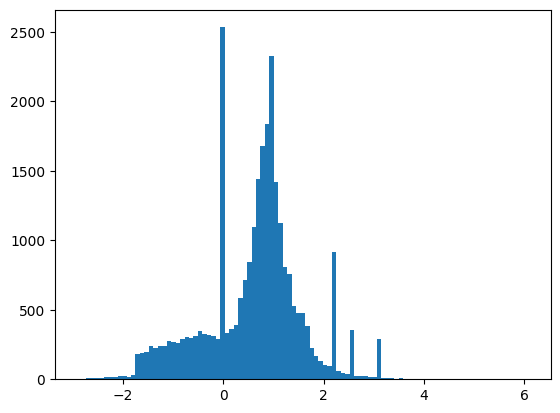

In [7]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

11.000.000 de amostras é um número elevado de amostras para treino. Para essa prática, usaremos as 1.000 amostras para validação e as próximas 10.000 para treinamento.

Usaremos os métodos `Dataset.skip` e `Dataset.take` para facilitar esse processo.

In [8]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

## *Overfitting* (sobreajuste)

A maneira mais simples de evitar o *overfitting* é começar com um modelo pequeno: um modelo com um pequeno número de parâmetros (que é determinado pelo número de camadas e o número de unidades por camada). No aprendizado profundo, o número de parâmetros que podem ser aprendidos em um modelo é geralmente chamado de "capacidade" do modelo.

Intuitivamente, um modelo com mais parâmetros terá mais "capacidade de memorização" e, portanto, poderá aprender facilmente um mapeamento perfeito do tipo dicionário entre amostras de treinamento e seus alvos, um mapeamento sem nenhum poder de **generalização**, mas isso seria inútil ao fazer previsões em dados inéditos.

Sempre tenha isso em mente: os modelos de aprendizado profundo tendem a ser bons em se ajustar aos dados de treinamento, mas o verdadeiro desafio é a **generalização**, não o ajuste.

Por outro lado, se a rede tiver recursos de memorização limitados, ela não conseguirá aprender o mapeamento com tanta facilidade. Para minimizar sua perda, ele terá que aprender representações compactadas que tenham mais poder preditivo. Ao mesmo tempo, se você tornar seu modelo muito pequeno, ele terá dificuldade em se ajustar aos dados de treinamento. Há um equilíbrio entre "capacidade demais" e "capacidade de menos".

Infelizmente, não existe uma fórmula mágica para determinar o tamanho certo ou a arquitetura do seu modelo (em termos de número de camadas ou o tamanho certo para cada camada). Você terá que experimentar usando uma série de arquiteturas diferentes.

Para encontrar um tamanho de modelo apropriado, é melhor começar com relativamente poucas camadas e parâmetros e, em seguida, começar a aumentar o tamanho das camadas ou adicionar novas camadas até ver retornos decrescentes na perda de validação.

Comece com um modelo simples usando apenas `layers.Dense` como linha de base, depois crie versões maiores e compare-as.

## Configurando o treinamento de modelos

Nesta prática iremos avaliar diversos modelos. Para que a análise seja facilitada, usaremos a mesma configuração para todos os modelos.

- Muitos modelos treinam melhor se você reduzir gradualmente a taxa de aprendizado durante o treinamento. Uma forma de utilizar isso em TensorFlow é por meio dos `optimizers.schedules`, os quais variam a taxa de aprendizado ao longo do tempo. Nesta prática utilizaremos o `InverseTimeDecay`.
- Utilizaremos como base o otimizador `tf.keras.optimizers.Adam`, o qual usará o `InverseTimeDecay` para regular a taxa de aprendizado.

In [9]:
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE # Total de amostras de treino / Batch size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

O código acima define um `schedules.InverseTimeDecay` para diminuir hiperbolicamente a taxa de aprendizado para 1/2 da taxa básica em 1.000 épocas, 1/3 em 2.000 épocas e assim por diante.

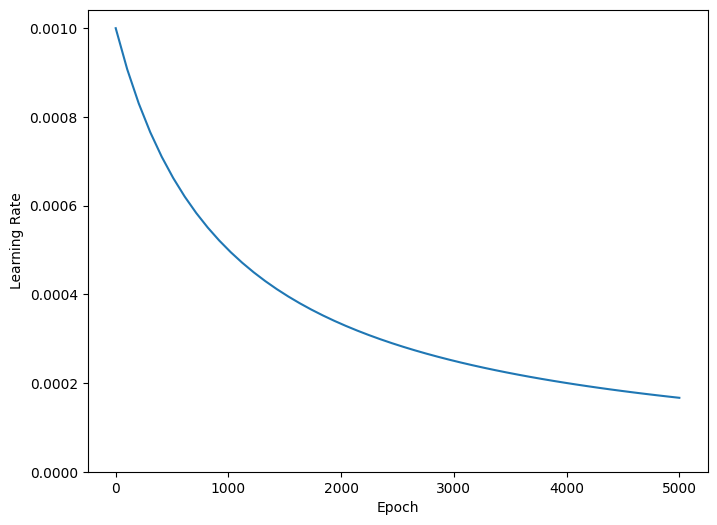

In [10]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

Outras Callbacks são necessárias:
- O treinamento para desta prática é executada por muitas épocas curtas. Para reduzir o ruído de log, use o `tfdocs.EpochDots` que simplesmente imprime `.` para cada época e um conjunto completo de métricas a cada 100 épocas.

- Para evitar tempos de treinamento longos e desnecessários, pode-se utilizar a `callbacks.EarlyStopping`. Observe que esse retorno de chamada é definido para monitorar o `val_binary_crossentropy` , não o `val_loss` . Essa diferença será importante mais tarde.
- Por fim, a `callbacks.TensorBoard` para gerar logs do TensorBoard para o treinamento.

In [11]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

def get_callbacks(name):
  return [
    EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

Por fim, iremos definir uma função para treinar e compilar os modelos.

In [12]:
def compile_and_fit(model, name, max_epochs=10000):
  optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.losses.BinaryCrossentropy(
                             from_logits=True,
                             name='binary_crossentropy'),
                         'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

## Treinando um modelo minúsculo

In [13]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

Criando uma variável para guardar a história dos modelos treinados.

In [14]:
size_histories = {}

Treinando o nosso pequeno modelo.

In [15]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(int(1e4)).repeat().batch(BATCH_SIZE)

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481 (1.88 KB)
Trainable params: 481 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5105,  binary_crossentropy:0.7397,  loss:0.7397,  val_accuracy:0.5120,  val_binary_crossentropy:0.7251,  val_loss:0.7251,  
....................................................................................................
Epoch: 100, accuracy:0.5998,  binary_crossentropy:0.6272,  loss:0.6272,  val_accuracy:0.5810,  val_binary_crossentropy:0.6255,  val_loss:0.6255,  
............................

### Verificando o modelo

(0.5, 0.7)

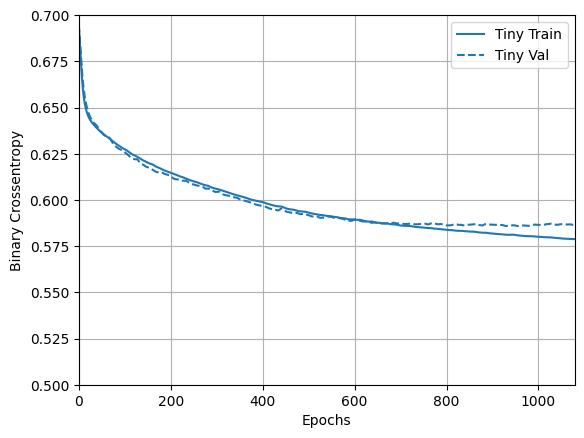

In [16]:
plotter = HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

As linhas sólidas mostram a `loss` de treinamento e as linhas tracejadas mostram a `loss` de validação (lembre-se: uma `loss` de validação menor indica um modelo melhor).

## Treinando um modelo pequeno

Uma forma de tentar superar o desempenho do modelo minúsculo é treinando progressivamente alguns modelos maiores.

No modelo minúsculo usamos somente uma camada de 16 neurônios. Vamos experimentar com duas camadas ocultas com 16 unidades.

In [17]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [18]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753 (2.94 KB)
Trainable params: 753 (2.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5002,  binary_crossentropy:0.8325,  loss:0.8325,  val_accuracy:0.5030,  val_binary_crossentropy:0.7492,  val_loss:0.7492,  
....................................................................................................
Epoch: 100, accuracy:0.6155,  binary_cros

### Verificando ambos modelos treinados

(0.5, 0.7)

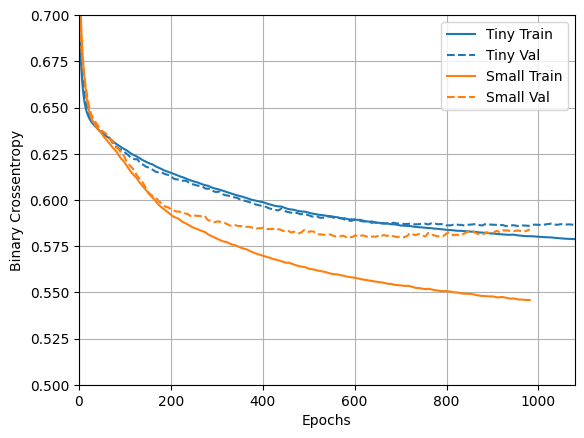

In [19]:
plotter = HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

## Treinando um modelo médio

Vamos tentar agora um modelo com 3 camadas e 64 neurônios por camada (quatro vezes mais).

In [20]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [21]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10241 (40.00 KB)
Trainable params: 10241 (40.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5046,  binary_crossentropy:0.6835,  loss:0.6835,  val_accuracy:0.5020,  val_binary_crossentropy:0.6704,  val_loss:0.6704,  
....

### Verificando os modelos treinados

(0.3, 0.7)

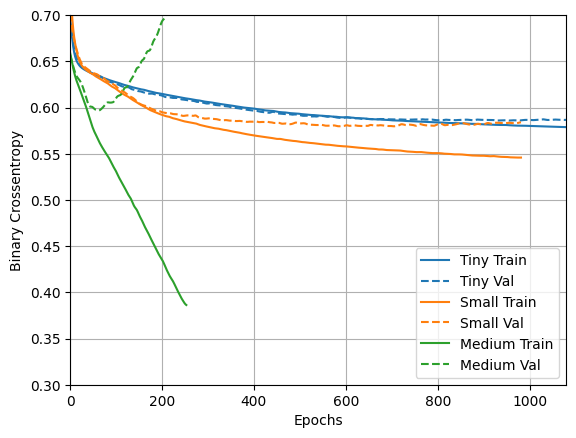

In [22]:
plotter = HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.3, 0.7])

## Treinando um modelo grande

Você pode criar um modelo ainda maior e verificar a rapidez com que ele começa a fazer overfitting. O novo modelo possui mais camadas e mais neurônios por camada (512).

In [23]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

### Verificando os modelos treinados

Embora a construção de um modelo maior lhe dê mais poder, se esse poder não for restringido de alguma forma, ele pode facilmente se ajustar ao conjunto de treinamento.

Neste exemplo, normalmente, apenas o modelo minúsculo (`"Tiny"`) consegue evitar completamente o overfitting, e cada um dos modelos maiores superajusta os dados mais rapidamente. Isso se torna tão grave para o modelo grande (`"Large"`) que você precisa mudar o gráfico para uma escala logarítmica para realmente descobrir o que está acontecendo.

Isso fica aparente se você plotar e comparar as métricas de validação com as métricas de treinamento.

* É normal que haja uma pequena diferença.
* Se ambas as métricas estiverem se movendo na mesma direção, está tudo bem.
* Se a métrica de validação começar a estagnar enquanto a métrica de treinamento continua a melhorar, você provavelmente está perto do overfitting.
* Se a métrica de validação estiver indo na direção errada, o modelo está claramente superajustado.

Text(0.5, 0, 'Epochs [Log Scale]')

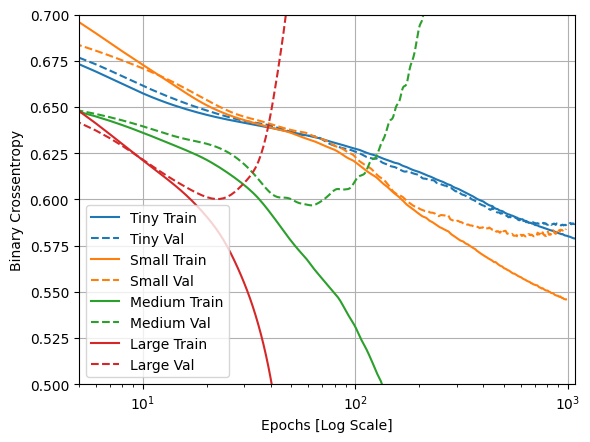

In [25]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

Todas as execuções de treinamento acima usaram o `callbacks.EarlyStopping` para encerrar o treinamento, uma vez que ficou claro que o modelo não estava progredindo.

## **ToDo:** Avaliando um modelo gigante (10pt)

Adicione a esse *benchmark* uma rede que tenha muito mais capacidade, muito mais do que o problema precisa.

In [28]:
### Seu código aqui
giant_model = tf.keras.Sequential([
    layers.Dense(1024, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1024, activation='elu'),
    layers.Dense(1024, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['giant'] = compile_and_fit(giant_model, "sizes/giant")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 1024)              29696     
                                                                 
 dense_27 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_28 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_29 (Dense)            (None, 512)               524800    
                                                                 
 dense_30 (Dense)            (None, 1)                 513       
                                                                 
Total params: 2654209 (10.13 MB)
Trainable params: 2654209 (10.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, acc

Text(0.5, 0, 'Epochs [Log Scale]')

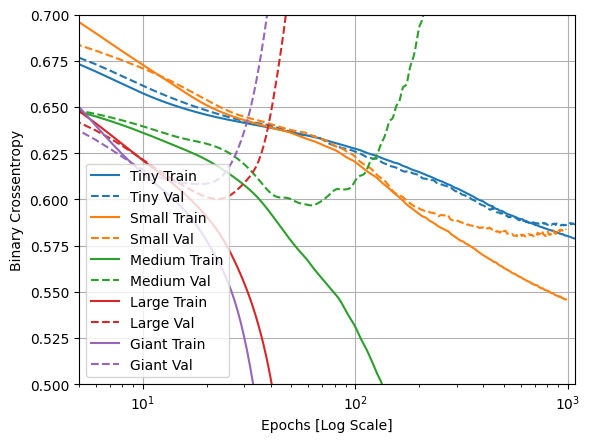

In [29]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

### **ToDo:** Avalie o seu modelo treinado conforme foi feito nos exemplos anteriores (10pt)

Segundo os resultados o modelo sugere que ele está aprendendo muito bem com os dados de treinamento, porém a binary crossentropy aumenta muito e isso pode ser causa de overfitting.

## Avaliando os resultados no *TensorBoard*

Salvamos os logs do TensorBoard durante o treinamento de todos os modelos treinados.

Podemos abrir um visualizador TensorBoard incorporado em um notebook.

In [30]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

<IPython.core.display.Javascript object>

### **ToDo:** Análises (10pt)

Quais análises você pode fazer sobre o TensorBoard?

`Escreva sua resposta aqui`

# Estratégias para previnir *overfitting* (sobreajuste)

Antes de entrar no conteúdo desta seção, copie os logs de treinamento do modelo minúsculo (`"Tiny"`) acima, para usar como linha de base para comparação.

Iremos comparar os logs de treinamento do modelo minúsculo (`"Tiny"`) acima, por isso iremos copiar os logs.

In [31]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpd316u6y7/tensorboard_logs/regularizers/Tiny')

In [33]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Adicionando estratégias de regularização ao modelo


Você pode estar familiarizado com o princípio da Navalha de Occam: dadas duas explicações para algo, a explicação mais provável de ser correta é a **mais simples**, aquela que faz a menor quantidade de suposições. Isso também se aplica aos modelos aprendidos pelas redes neurais: dados alguns dados de treinamento e uma arquitetura de rede, existem vários conjuntos de valores de pesos (múltiplos modelos) que podem explicar os dados, e modelos mais simples são menos propensos a sobreajustar do que os complexos.

Um "modelo simples" neste contexto é um modelo onde a distribuição de valores de parâmetros tem menos entropia (ou um modelo com menos parâmetros, como demonstrado na seção acima). Assim, uma maneira comum de mitigar o *overfitting* é colocar restrições na complexidade de uma rede, forçando seus pesos apenas a assumir valores pequenos, o que torna a distribuição de valores de peso mais "regular". Isso é chamado de "regularização de peso", e é feito adicionando à função de perda da rede um custo associado a ter grandes pesos. Este custo vem em dois sabores:

* [Regularização L1](https://developers.google.com/machine-learning/glossary/#L1_regularization), onde o custo adicionado é proporcional ao valor absoluto dos coeficientes dos pesos (ou seja, ao que é chamado de "norma L1 "dos pesos).

* [Regularização L2](https://developers.google.com/machine-learning/glossary/#L2_regularization), onde o custo adicionado é proporcional ao quadrado do valor dos coeficientes dos pesos (ou seja, ao que é chamado de quadrado "norma L2" dos pesos). A regularização L2 também é chamada de decaimento de peso no contexto de redes neurais. Não deixe que o nome diferente o confunda: a redução de peso (*weight decay*) é matematicamente igual à regularização L2.

A regularização L1 empurra os pesos para zero, incentivando um modelo esparso. A regularização de L2 penalizará os parâmetros de pesos sem torná-los esparsos, já que a penalidade vai para zero para pesos pequenos - uma razão pela qual L2 é mais comum.

Em `tf.keras`, a regularização de peso é adicionada passando instâncias do regularizador de peso para camadas como argumentos de palavras-chave. Adicione regularização de peso L2:

In [34]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 512)               14848     
                                                                 
 dense_32 (Dense)            (None, 512)               262656    
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 dense_34 (Dense)            (None, 512)               262656    
                                                                 
 dense_35 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803329 (3.06 MB)
Trainable params: 803329 (3.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accurac

`l2(0,001)` significa que cada coeficiente na matriz de peso da camada adicionará `0,001 * weight_coeficiente_value**2` ao total de **perda** da rede.

É por isso que estamos monitorando o `binary_crossentropy` diretamente. Porque não tem esse componente de regularização misturado.

Então, esse mesmo modelo `"Large"` com uma penalidade de regularização `L2` tem um desempenho muito melhor:


(0.5, 0.7)

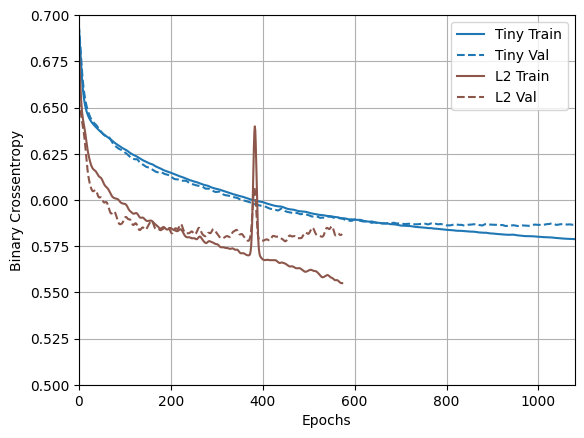

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Conforme demonstrado, o modelo regularizado `"L2"` agora é muito mais competitivo com o modelo `"Tiny"`. Este modelo `"L2"` também é muito mais resistente ao overfitting do que o modelo `"Large"` no qual foi baseado, apesar de ter o mesmo número de parâmetros.

### Adicionando *dropout*

Dropout é uma das técnicas de regularização mais eficazes e mais utilizadas para redes neurais, desenvolvida por Hinton e seus alunos da Universidade de Toronto.

A explicação intuitiva para o dropout é que, como os nós individuais na rede não podem contar com a saída dos outros, cada nó deve produzir recursos que sejam úteis por conta própria.

O dropout, aplicado a uma camada, consiste em "descartar" aleatoriamente (ou seja, definir como zero) um número de recursos de saída da camada durante o treinamento. Por exemplo, uma determinada camada normalmente retornaria um vetor `[0.2, 0.5, 1.3, 0.8, 1.1]` para uma determinada amostra de entrada durante o treinamento; após aplicar dropout, este vetor terá algumas entradas zero distribuídas aleatoriamente, por exemplo. `[0, 0,5, 1,3, 0, 1,1]`.

A "taxa de abandono" é a fração dos recursos que estão sendo zerados; geralmente é definido entre 0,2 e 0,5. No momento do teste, nenhuma unidade é descartada e, em vez disso, os valores de saída da camada são reduzidos por um fator igual à taxa de abandono, de modo a equilibrar o fato de que mais unidades estão ativas do que no tempo de treinamento.

No Keras, você pode introduzir dropout em uma rede através da camada `tf.keras.layers.Dropout`, que é aplicada à saída da camada imediatamente anterior.

Adicione duas camadas de dropout à sua rede para verificar o desempenho delas na redução do overfitting:

In [36]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_39 (Dense)            (None, 512)              

(0.5, 0.7)

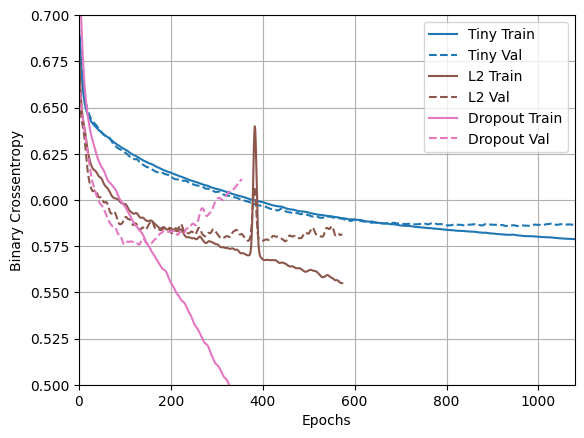

In [37]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Fica claro neste gráfico que ambas as abordagens de regularização melhoram o comportamento do modelo grande (`"Large"`). Mas isso ainda não supera nem mesmo a linha de base `"Tiny"`.

Naturalmente, o próximo passo é testar os dois juntos.

### Combinando L2 + *dropout*

In [38]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_43 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_44 (Dense)            (None, 512)              

(0.5, 0.7)

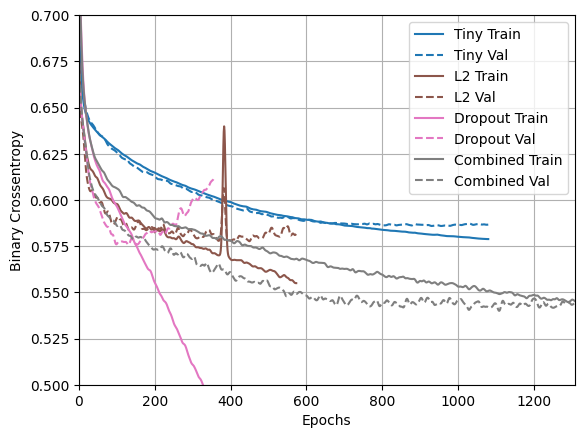

In [39]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

Este modelo com as regularizações combinadas (`"Combined"`) é obviamente o melhor até agora.

### Avaliando os resultados no *TensorBoard*


Esses modelos também registraram logs do TensorBoard.

Para abrir um visualizador de tensorboard incorporado em um notebook, copie o seguinte em uma célula de código:

```
%tensorboard --logdir {logdir}/regularizers
```

#### **ToDo:** Análise dos resultados (10pt)

O que você pode inferir analisando os resultados apresentados no TensorBoard?

` Escreva sua resposta aqui `

# Avaliando estrátegias de *overfitting* e regularização para a base de gato/não-gato

Para essa próxima tarefa, avalie três modelos (semelhante ao que foi feito para a base de Higgs). Você deve treinar:
- Um modelo pequeno.
- Um modelo médio.
- Um modelo grande.

Criando uma variável para guardar a história dos modelos treinados.

In [40]:
cat_histories = {}

## **ToDo:** Lendo os dados da base de gatos/não-gatos (10pt)

In [41]:
### Seu código aqui
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy

from sklearn.metrics import accuracy_score

from tensorflow import keras
from google.colab import drive
drive.mount('/content/drive')


# Função para ler os dados (gato/não-gato)
def load_dataset():
    def _load_data():
      train_dataset = h5py.File('drive/MyDrive/train_catvnoncat.h5', "r")
      train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
      train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

      test_dataset = h5py.File('drive/MyDrive/test_catvnoncat.h5', "r")
      test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
      test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

      classes = np.array(test_dataset["list_classes"][:]) # the list of classes
      train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
      test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

      return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

    def _preprocess_dataset(_treino_x_orig, _teste_x_orig):
      # Formate o conjunto de treinamento e teste dados de treinamento e teste para que as imagens
      # de tamanho (num_px, num_px, 3) sejam vetores de forma (num_px * num_px * 3, 1)
      _treino_x_vet = _treino_x_orig.reshape(_treino_x_orig.shape[0], -1) # ToDo: vetorizar os dados de treinamento aqui
      _teste_x_vet = _teste_x_orig.reshape(_teste_x_orig.shape[0], -1) # ToDo: vetorizar os dados de teste aqui

      # Normalize os dados (colocar no intervalo [0.0, 1.0])
      _treino_x = _treino_x_vet/255. # ToDo: normalize os dados de treinamento aqui
      _teste_x = _teste_x_vet/255. # ToDo: normalize os dados de teste aqui
      return _treino_x, _teste_x

    treino_x_orig, treino_y, teste_x_orig, teste_y, classes = _load_data()
    treino_x, teste_x = _preprocess_dataset(treino_x_orig, teste_x_orig)
    return treino_x, treino_y, teste_x, teste_y, classes

# Lendo os dados (gato/não-gato)
treino_x, treino_y, teste_x, teste_y, classes = load_dataset()

Mounted at /content/drive


In [46]:
# Lendo os dados (gato/não-gato)
treino_x, treino_y, teste_x, teste_y, classes = load_dataset()

In [47]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

def get_callbacks(name):
  return [
    EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [48]:
def compile_and_fit_cat(model, name, max_epochs=10000):
  optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.keras.losses.BinaryCrossentropy(
                             from_logits=True,
                             name='binary_crossentropy'),
                         'accuracy'])

  model.summary()

  history = model.fit(
    treino_x,
    treino_y.reshape(-1),
    validation_split = 0.1,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

## **ToDo:** Treinando um modelo pequeno (10pt)

In [57]:
modelo_pequeno = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(12288,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
cat_histories['Pequeno'] = compile_and_fit_cat(modelo_pequeno, 'sizes/Pequeno')

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 16)                196624    
                                                                 
 dense_82 (Dense)            (None, 16)                272       
                                                                 
 dense_83 (Dense)            (None, 1)                 17        
                                                                 
Total params: 196913 (769.19 KB)
Trainable params: 196913 (769.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch: 0, accuracy:0.5556,  binary_crossentropy:0.8551,  loss:0.8574,  val_accuracy:0.7619,  val_binary_crossentropy:0.6034,  val_loss:0.6034,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  

## **ToDo:** Treinando um modelo médio (10pt)

In [59]:
modelo_medio = tf.keras.Sequential([
    ## Seu código aqui
    layers.Dense(64, activation='elu', input_shape=(12288,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
cat_histories['Medio'] = compile_and_fit(modelo_medio, 'sizes/Medio')

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                786496    
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 1)                 65        
                                                                 
Total params: 794881 (3.03 MB)
Trainable params: 794881 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: ignored

## **ToDo:** Treinando um modelo grande (10pt)

In [53]:
modelo_grande = tf.keras.Sequential([
    ## Seu código aqui
    layers.Dense(512, activation='elu', input_shape=(12288,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
cat_histories['Grande'] = compile_and_fit(modelo_pequeno, 'sizes/Grande')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 16)                196624    
                                                                 
 dense_50 (Dense)            (None, 16)                272       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 196913 (769.19 KB)
Trainable params: 196913 (769.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: ignored

## **ToDo:** Avalie a adição de regularização aos modelos (10pt)

In [54]:
modelo_com_regularizacao = tf.keras.Sequential([
    ## Seu código aqui
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(12288,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])
cat_histories['Regularizacao'] = compile_and_fit(modelo_pequeno, 'sizes/Regularizacao')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 16)                196624    
                                                                 
 dense_50 (Dense)            (None, 16)                272       
                                                                 
 dense_51 (Dense)            (None, 1)                 17        
                                                                 
Total params: 196913 (769.19 KB)
Trainable params: 196913 (769.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: ignored

## Resultados do treinamento

In [ ]:
plotter.plot(cat_histories)
plt.ylim([0.5, 0.7])

## **ToDo:** Análise dos resultados (10pt)

In [ ]:
from sklearn.metrics import classification_report

y_pred_pequeno = modelo_pequeno.predict(teste_x)
y_pred_pequeno = (y_pred_pequeno > 0.5).astype(int)
y_pred_pequeno = y_pred_pequeno.reshape((50,))
report_pequeno = classification_report(teste_y[0], y_pred_pequeno, target_names=classes)
print("Relatório de classificação para o modelo Pequeno:\n", report_pequeno)

y_pred_medio = modelo_medio.predict(teste_x)
y_pred_medio = (y_pred_medio > 0.5).astype(int)
y_pred_medio = y_pred_medio.reshape((50,))
report_medio = classification_report(teste_y[0], y_pred_medio, target_names=classes)
print("Relatório de classificação para o modelo Médio:\n", report_medio)

y_pred_grande = modelo_grande.predict(teste_x)
y_pred_grande = (y_pred_grande > 0.5).astype(int)
y_pred_grande = y_pred_grande.reshape((50,))
report_grande = classification_report(teste_y[0], y_pred_grande, target_names=classes)
print("Relatório de classificação para o modelo Grande:\n", report_grande)

y_pred_regularizacao = modelo_com_regularizacao.predict(teste_x)
y_pred_regularizacao = (y_pred_regularizacao > 0.5).astype(int)
y_pred_regularizacao = y_pred_regularizacao.reshape((50,))
report_regularizacao = classification_report(teste_y[0], y_pred_regularizacao, target_names=classes)
print("Relatório de classificação para o modelo com Regularização:\n", report_regularizacao)

Avalia os modelos treinados quanto a Acurácia, F1-score, Precisão e revocação.

Dica: utilize a função [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) da sklearn.

O que você pode inferir analisando os resultados dos treinamentos para a base de gatos/não-gatos.

` Escreva sua resposta aqui `